# Time Causal VAE

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import yaml
sys.path.append('../src')
from tsvae.utils.logger_utils import get_console_logger
logger = get_console_logger(__name__)
from os import path as pt

## Data used in original paper

(2516, 2)


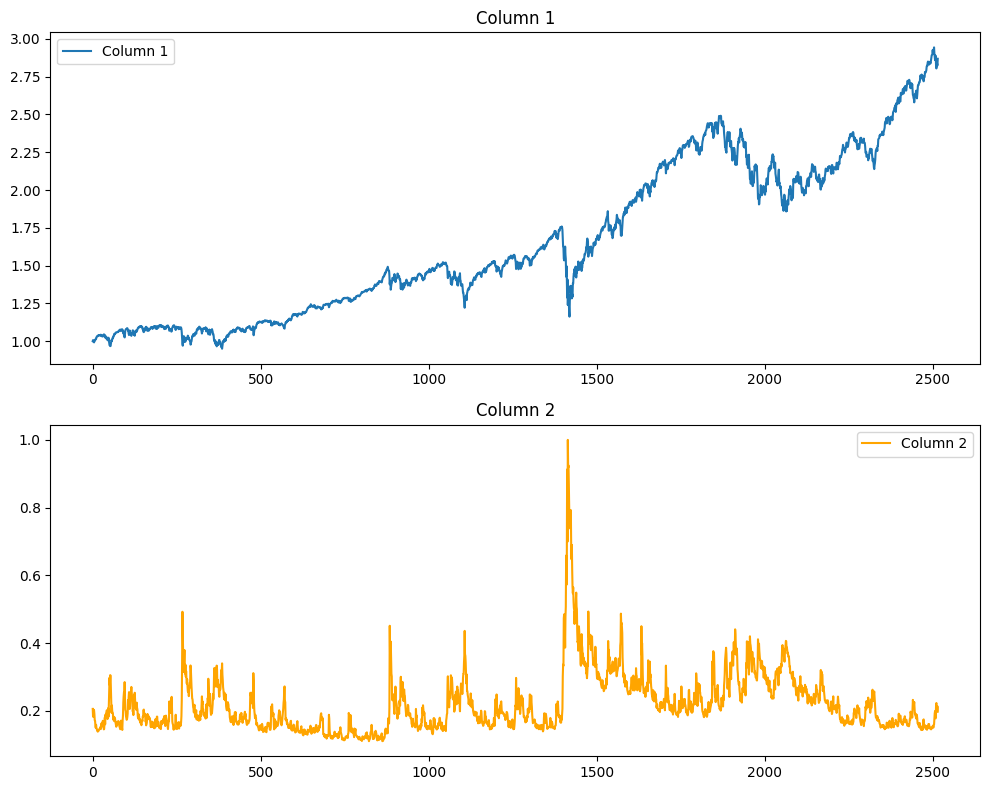

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("../data/sp500vix/sp500vix_normalized.npy")
print(data.shape)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(data[:, 0], label="Column 1")
axs[0].set_title("Column 1")
axs[0].legend()

axs[1].plot(data[:, 1], label="Column 2", color="orange")
axs[1].set_title("Column 2")
axs[1].legend()

plt.tight_layout()
plt.show()


## Create Data for Master Thesis

In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv("../../../../../data/raw/spy_daily_closing_prices.csv", index_col = 0)
# df["vol"] = df["Close"].rolling(window=30).std()
# df = df.dropna()
data = df.to_numpy()
data[:, 0] = data[:, 0]/data[0, 0]
data[:, 1] = data[:, 1]/np.max(data[:, 1])
print(data.shape)
np.save("../data/sp500vix/sp500_normalized.npy", data)



(1089, 2)


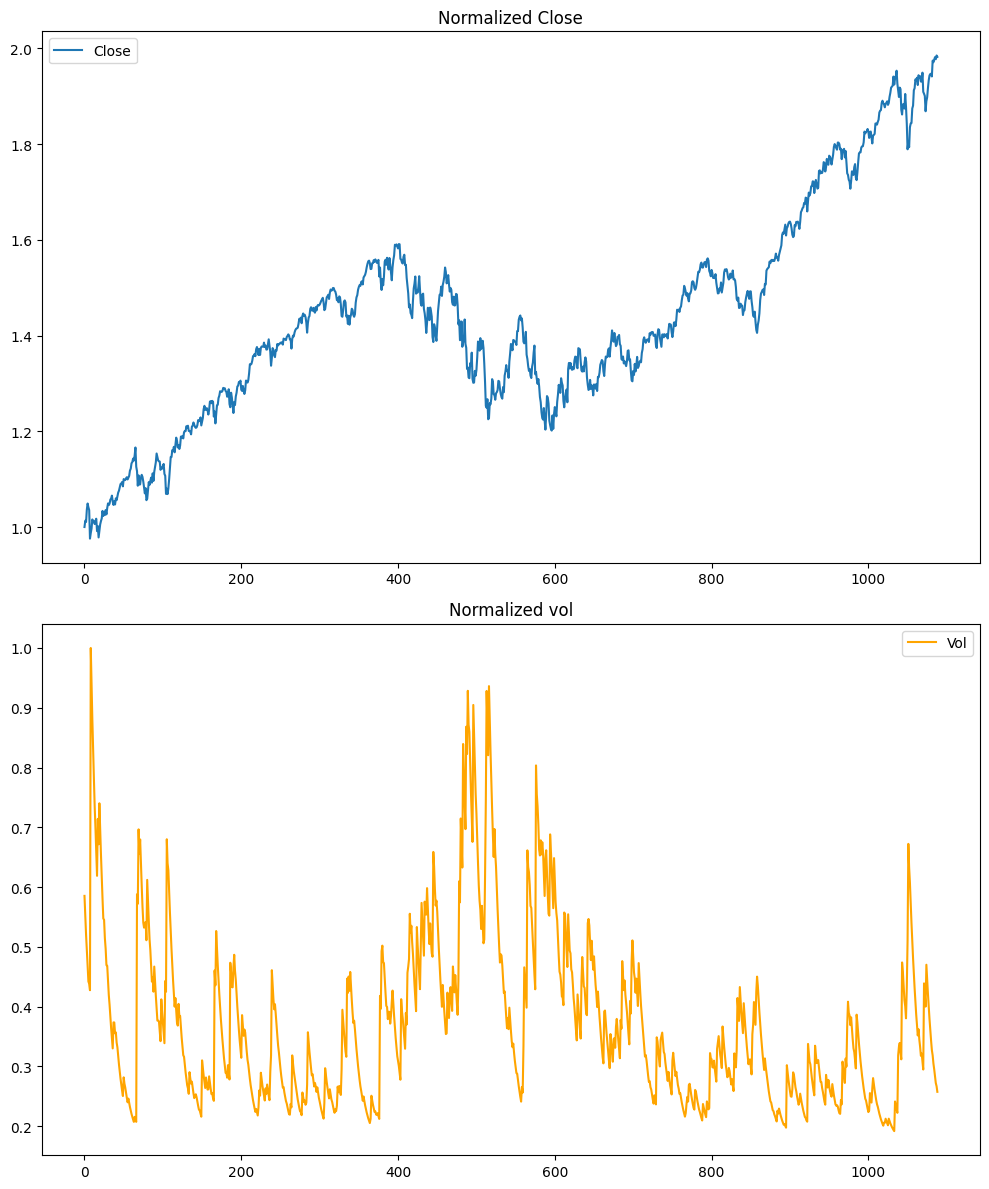

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].plot(data[:, 0], label="Close")
axs[0].set_title("Normalized Close")
axs[0].legend()

axs[1].plot(data[:, 1], label="Vol", color="orange")
axs[1].set_title("Normalized vol")
axs[1].legend()

# axs[2].plot(rolling_volatility, label="30-Day Rolling Volatility", color="green")
# axs[2].set_title("30-Day Rolling Volatility of Column 1")
# axs[2].legend()

plt.tight_layout()
plt.show()

## TCVAE Model

In [20]:
from experiments.experiment_utils import get_output_dir, update_config
from tsvae.dataset.data_pipeline import DataPipeline
from tsvae.models.network_pipeline import NetworkPipeline
from tsvae.utils.random_utils import set_seed


base_output_dir = '..' 
new_config = {'epochs' : 100, 'wandb': False, 'comment': 'test'}
exp_config_path = '../configs/Master/betacvae.yaml'

with open(exp_config_path) as file:
    exp_config = dict(yaml.safe_load(file))

exp_config = update_config(exp_config, new_config)

exp_config.base_output_dir = base_output_dir
exp_config.output_dir = get_output_dir(exp_config)
logger.info(f"Experiment results saved to {exp_config.output_dir}")

logger.info(f"Saving experiment config to {exp_config.output_dir}")
config_file_path = pt.join(exp_config.output_dir, "exp_config.yaml")
with open(config_file_path, "w") as outfile:
    yaml.dump(exp_config, outfile, default_flow_style=False)
# logger.info(exp_config)

# Generating data
logger.info(f"Setting ramdom seed: {exp_config.seed}")
set_seed(exp_config.seed)

Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Setting ramdom seed: 0


In [21]:
logger.info(f"Loading dataset: {exp_config.dataset}")
data_pipeline = DataPipeline()
train_dataset, eval_dataset = data_pipeline(exp_config)

# Loading network
logger.info("Load networks:")
network_pipeline = NetworkPipeline()
model = network_pipeline(exp_config)
# logger.info(f"{model}")

Loading dataset: Master
Base dataset initialized
Load networks:


In [22]:
from tsvae.trainers.base_trainer_config import BaseTrainerConfig
from tsvae.trainers.training_pipeline import TrainingPipeline


training_config = BaseTrainerConfig(
    output_dir=exp_config.output_dir,
    learning_rate=exp_config.lr,
    per_device_train_batch_size=exp_config.train_batch_size,
    per_device_eval_batch_size=exp_config.eval_batch_size,
    optimizer_cls=exp_config.optimizer,
    optimizer_params=None,
    scheduler_cls=None,
    scheduler_params=None,
    steps_saving=exp_config.steps_saving,
    steps_predict=exp_config.steps_predict,
    seed=exp_config.seed,
    num_epochs=exp_config.epochs,
    wandb_callback=exp_config.wandb,
    wandb_output_dir=exp_config.base_output_dir + "/wandb",
)

train_pipeline = TrainingPipeline(model=model, training_config=training_config, exp_config=exp_config)

trainer = train_pipeline(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    device_name=exp_config.device_name,
)

Path Visualization of data
Model passed sanity check !
Ready for training.



In [23]:
train_pipeline.train(log_output=True)

Created ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test/BetaCVAE_training_2025-03-21_18-15-04. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: 30
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Scheduler: None
Device: cpu

Successfully launched training !

total loss: 4.17
recon: 3.82
reg: 8.66


Eval of epoch 1/100:  20%|██        | 1/5 [00:00<00:00,  4.41batch/s]
--------------------------------------------------------------------------
Train loss: 7.2851
--------------------------------------------------------------------------
total loss: 1.79
recon: 1.58
reg: 5.40


Eval of epoch 2/100: 

In [24]:
from evaluations.hyperparameter import ModelEvaluator
from os import path as pt

model_dir = pt.join(trainer.training_dir, 'final_model')
model_evaluator = ModelEvaluator(model_dir)
output_dir = model_evaluator.hyper_model_dir
model = model_evaluator.model

test_data, gen_data, recon_data = model_evaluator.load_data(seed = 99, n_sample_test=1031)
ds = model_evaluator.data_ppl.base_dataset

real_data = test_data
recon_data = recon_data
fake_data = gen_data

Base dataset initialized


## Real Data (l) and Fake Data (r)

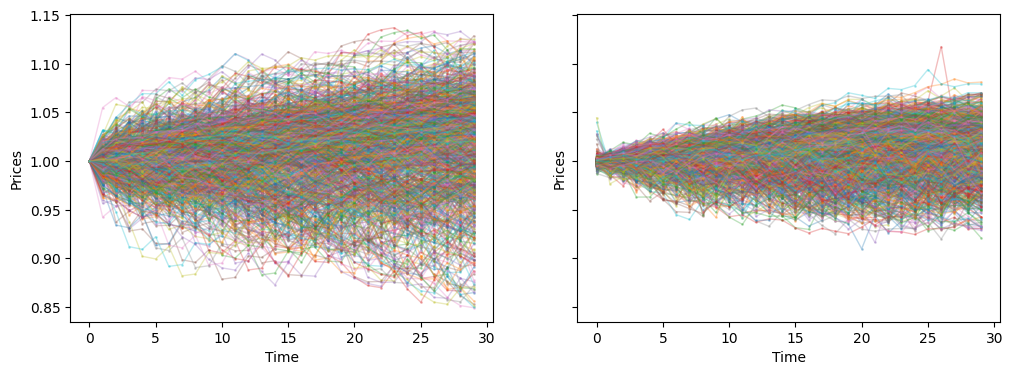

In [25]:
from evaluations.compare import compare_path
compare_path(real_data,fake_data, plot_size=1000)